In [5]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax


0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [3]:
!gdown 166rhp9yMFCuyAOBKJtZJZFFTt3YQUrlQ

Downloading...
From (original): https://drive.google.com/uc?id=166rhp9yMFCuyAOBKJtZJZFFTt3YQUrlQ
From (redirected): https://drive.google.com/uc?id=166rhp9yMFCuyAOBKJtZJZFFTt3YQUrlQ&confirm=t&uuid=b5ebc977-89d4-4211-8f25-1a878d7c6eaa
To: /content/icml_face_data.csv
100% 301M/301M [00:05<00:00, 57.1MB/s]


In [6]:
df = pd.read_csv('/content/icml_face_data.csv', skipinitialspace = True)
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [7]:
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

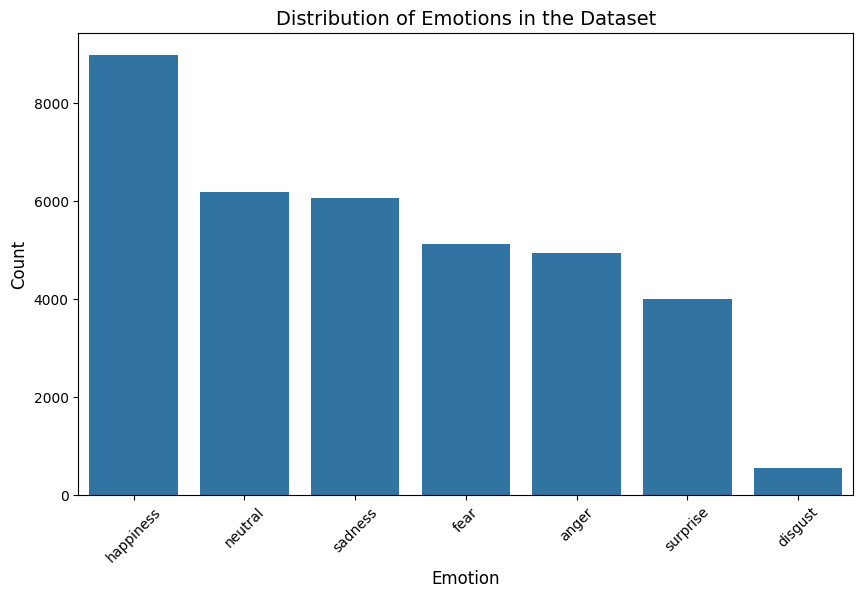

In [8]:
emotion_counts = df['emotion'].value_counts()
emotion_labels = emotion_counts.index.map(lambda x: label_to_text[x])

plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_labels, y=emotion_counts)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Emotions in the Dataset", fontsize=14)
plt.xticks(rotation=45)
plt.show()


In [ ]:
EMOTION_CLASS = [3, 4, 6]
df = df[df.emotion.isin(EMOTION_CLASS)]
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
Name: count, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21264 entries, 3 to 35885
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  21264 non-null  int64 
 1   Usage    21264 non-null  object
 2   pixels   21264 non-null  object
dtypes: int64(1), object(2)
memory usage: 664.5+ KB


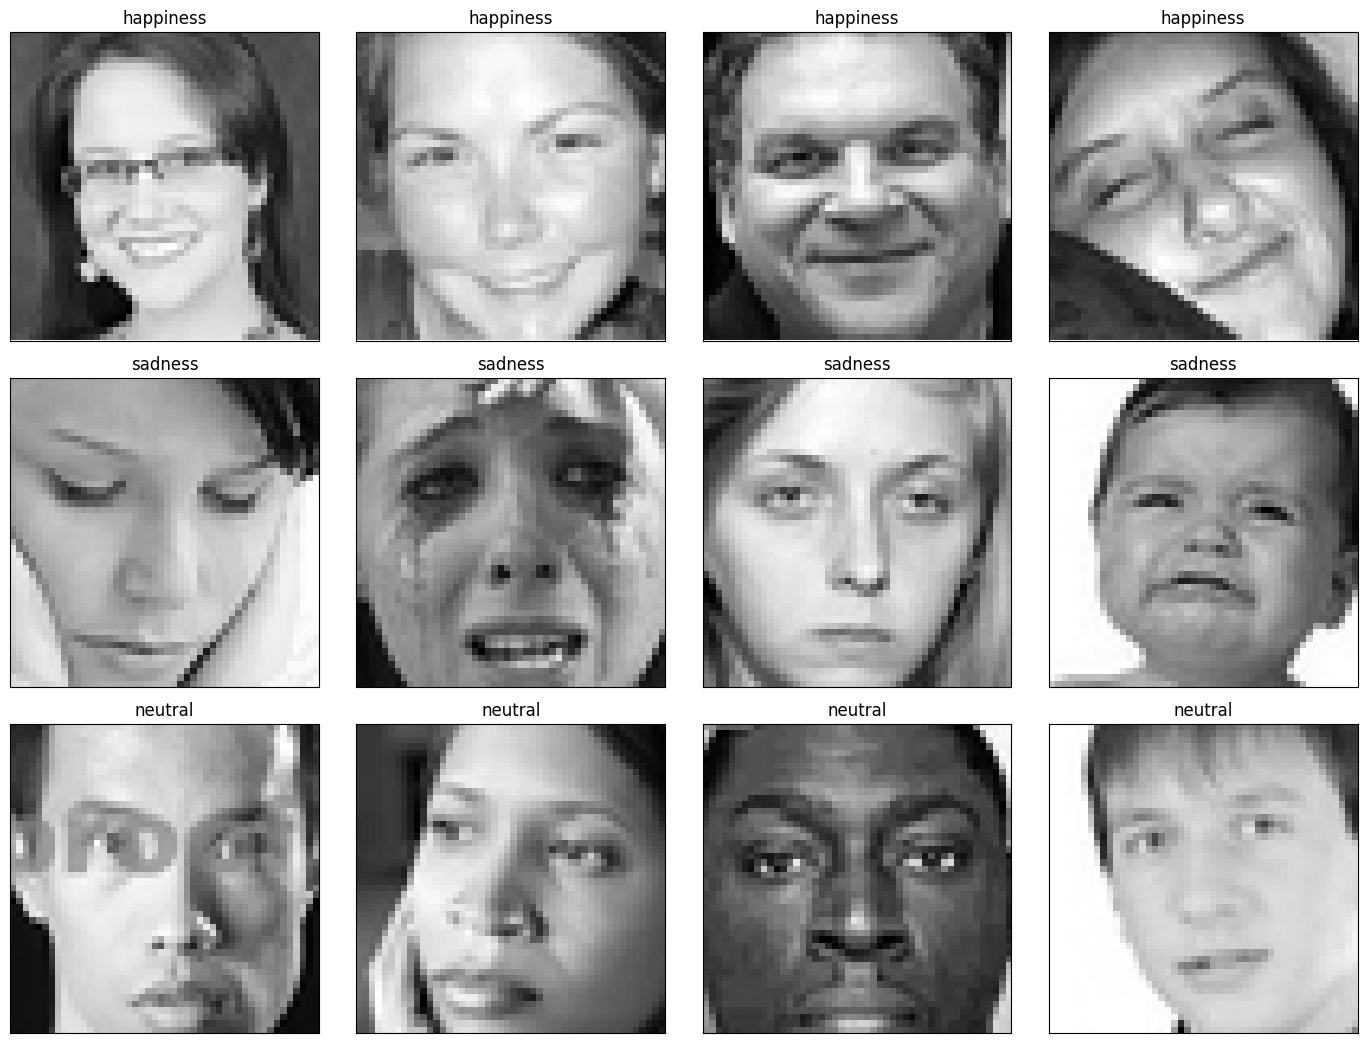

In [ ]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(4):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(4, 4, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()

In [ ]:
# Convert pixel strings to NumPy arrays and reshape them into 48x48 grayscale images
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))

# Stack the individual 48x48x1 arrays into a single NumPy array
img_array = np.stack(img_array, axis=0)

In [ ]:
from keras.utils import to_categorical
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
# Convert numerical labels to one-hot encoded labels
img_labels = to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [ ]:
# Mapping original class labels to numerical values
name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print(name_mapping)

{3: 0, 4: 1, 6: 2}


In [ ]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [ ]:
WIDTH = X_train.shape[1]
HEIGHT = X_train.shape[2]
DEPTH = X_train.shape[3]
NUM_CLASSES = y_train.shape[1]

In [ ]:
# Normalize
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
model = Sequential(name='CNN')

model.add(Conv2D(64, (5,5), input_shape=(WIDTH, HEIGHT, DEPTH), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_1'))
model.add(BatchNormalization(name='batchnorm_1'))
model.add(Conv2D(64, (5,5), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_2'))
model.add(BatchNormalization(name='batchnorm_2'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
model.add(Dropout(0.4, name='dropout_1'))

model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_3'))
model.add(BatchNormalization(name='batchnorm_3'))
model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_4'))
model.add(BatchNormalization(name='batchnorm_4'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
model.add(Dropout(0.4, name='dropout_2'))

model.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_5'))
model.add(BatchNormalization(name='batchnorm_5'))
model.add(Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_6'))
model.add(BatchNormalization(name='batchnorm_6'))

model.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
model.add(Dropout(0.5, name='dropout_3'))

model.add(Flatten(name='flatten'))

model.add(Dense(128, activation='elu', kernel_initializer='he_normal', name='dense_1'))
model.add(BatchNormalization(name='batchnorm_7'))

model.add(Dropout(0.6, name='dropout_4'))

model.add(Dense(NUM_CLASSES, activation='softmax', name='out_layer'))

# Compile the model
optimizer = Adamax(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0       

In [ ]:
!pip install visualkeras

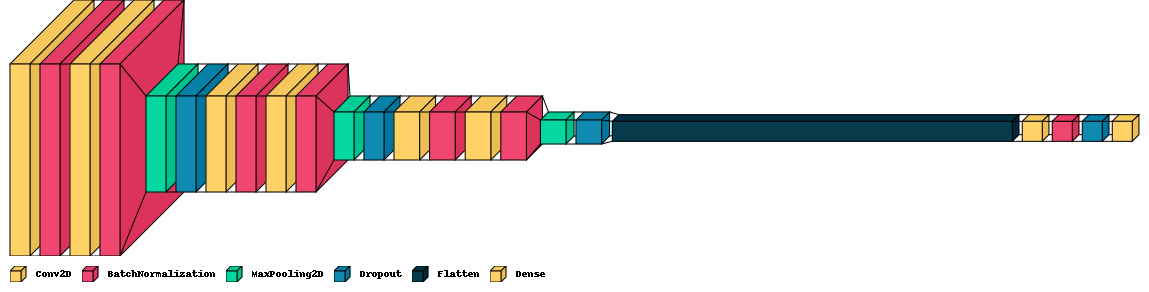

In [ ]:
import visualkeras
visualkeras.layered_view(model, to_file='model.png', legend=True)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
# Training parameters
batch_size = 32
epochs = 100

# Train the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/100


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


596/598 [============================>.] - ETA: 0s - loss: 1.4812 - accuracy: 0.3854

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


598/598 [==============================] - 27s 37ms/step - loss: 1.4802 - accuracy: 0.3856 - val_loss: 1.1016 - val_accuracy: 0.4805 - lr: 0.0010
Epoch 2/100
598/598 [==============================] - 20s 33ms/step - loss: 1.1511 - accuracy: 0.4274 - val_loss: 0.9861 - val_accuracy: 0.5242 - lr: 0.0010
Epoch 3/100
598/598 [==============================] - 23s 38ms/step - loss: 1.0458 - accuracy: 0.4705 - val_loss: 0.9639 - val_accuracy: 0.5284 - lr: 0.0010
Epoch 4/100
598/598 [==============================] - 21s 35ms/step - loss: 0.9892 - accuracy: 0.5099 - val_loss: 0.8760 - val_accuracy: 0.5816 - lr: 0.0010
Epoch 5/100
598/598 [==============================] - 21s 34ms/step - loss: 0.9112 - accuracy: 0.5549 - val_loss: 0.8046 - val_accuracy: 0.6469 - lr: 0.0010
Epoch 6/100
598/598 [==============================] - 22s 36ms/step - loss: 0.8345 - accuracy: 0.6044 - val_loss: 0.7522 - val_accuracy: 0.6554 - lr: 0.0010
Epoch 7/100
598/598 [==============================] - 22s 37ms/

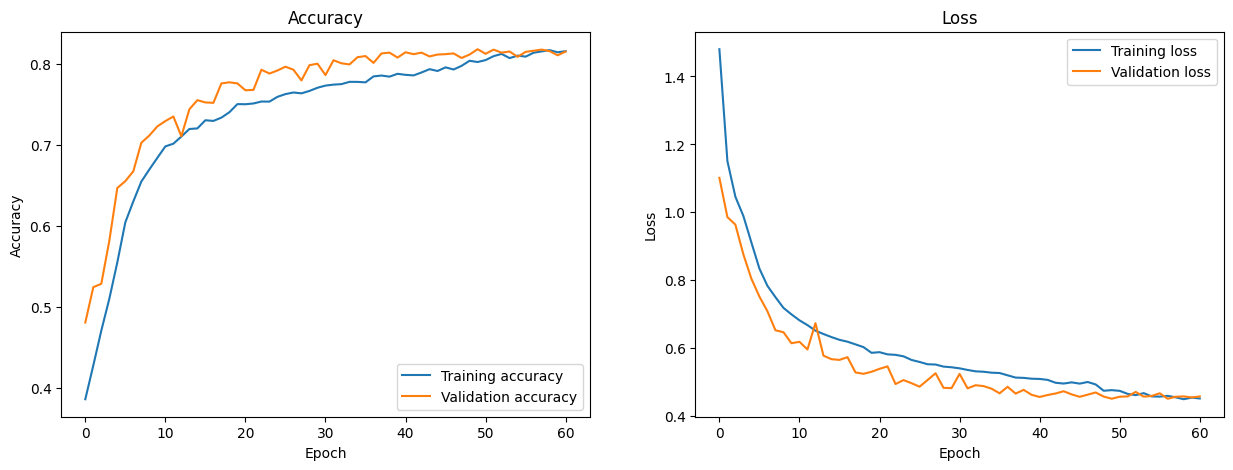

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the accuracy curves
ax1.plot(epochs, acc, label='Training accuracy')
ax1.plot(epochs, val_acc, label='Validation accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot the loss curves
ax2.plot(epochs, loss, label='Training loss')
ax2.plot(epochs, val_loss, label='Validation loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

# Show the plot
plt.show()


67/67 [==============================] - 1s 12ms/step


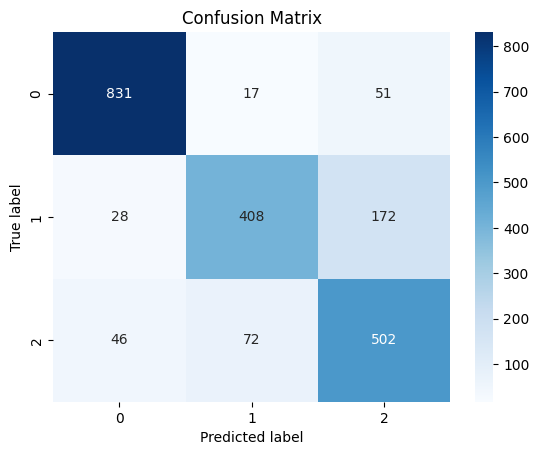

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_valid)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_valid, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model_path = "/content/drive/MyDrive/Emotion_recognization/model.keras"
model.save(model_path)
